In [1]:
import pandas as pd
import statsmodels.api as sm
import unicodedata

wins_df = pd.read_csv("../data/NBATrackingDataWins24-25_per36.csv")
losses_df = pd.read_csv("../data/NBATrackingDataLosses24-25_per36.csv")

# Define Superstar and Secondary Star lists
superstars = [
    "Luka Doncic", "Giannis Antetokounmpo", "Nikola Jokic",
    "Jayson Tatum", "Shai Gilgeous-Alexander", "Stephen Curry",
    "LeBron James", "Kevin Durant", "Joel Embiid", "Anthony Davis",
    "Anthony Edwards", "Jalen Brunson", "Victor Wembanyama",
    "Devin Booker", "Kawhi Leonard", "Trae Young", "Donovan Mitchell"
]

secondary_stars = [
    "Jaylen Brown", "Jimmy Butler III", "De'Aaron Fox",
    "Kyrie Irving", "Ja Morant", "Zion Williamson", "Bam Adebayo",
    "Pascal Siakam", "Brandon Ingram", "Domantas Sabonis", "Karl-Anthony Towns",
    "Jamal Murray", "Darius Garland", "Damian Lillard", "Jalen Williams",
    "Paul George", "Scottie Barnes", "Paolo Banchero", "Tyrese Haliburton",
    "Tyrese Maxey", "Lauri Markkanen", "Mikal Bridges", "Franz Wagner",
    "Desmond Bane", "Chet Holmgren", "Kristaps Porzingis", "Jrue Holiday",
    "Dejounte Murray"
]

# Function to strip accents
def remove_accents(name):
    if isinstance(name, str):
        return ''.join(
            c for c in unicodedata.normalize('NFD', name)
            if unicodedata.category(c) != 'Mn'
        )
    return name

# Categorize players in both datasets 
def categorize_by_name(player):
    if player in superstars:
        return "Superstar"
    elif player in secondary_stars:
        return "Secondary Star"
    else:
        return "Role Player"

# Apply to both datasets
wins_df["PLAYER"] = wins_df["PLAYER"].apply(remove_accents)
losses_df["PLAYER"] = losses_df["PLAYER"].apply(remove_accents)

wins_df["Tier"] = wins_df["PLAYER"].apply(categorize_by_name)
losses_df["Tier"] = losses_df["PLAYER"].apply(categorize_by_name)

wins_df["Tier"].value_counts()

Tier
Role Player       502
Secondary Star     28
Superstar          17
Name: count, dtype: int64

Model Performance Summary


,Tier,Outcome,Model,R²,RMSE
0,Superstar,Wins,Random Forest,0.479,1.414
1,Superstar,Wins,XGBoost,0.645,1.167
2,Superstar,Losses,Random Forest,0.318,2.059
3,Superstar,Losses,XGBoost,0.143,2.308
4,Secondary Star,Wins,Random Forest,0.877,0.865
5,Secondary Star,Wins,XGBoost,0.877,0.867
6,Secondary Star,Losses,Random Forest,0.808,1.150
7,Secondary Star,Losses,XGBoost,0.789,1.206
8,Role Player,Wins,Random Forest,0.762,1.157
9,Role Player,Wins,XGBoost,0.812,1.029


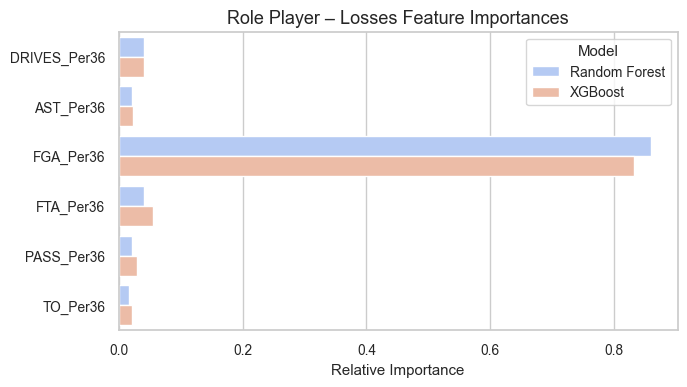

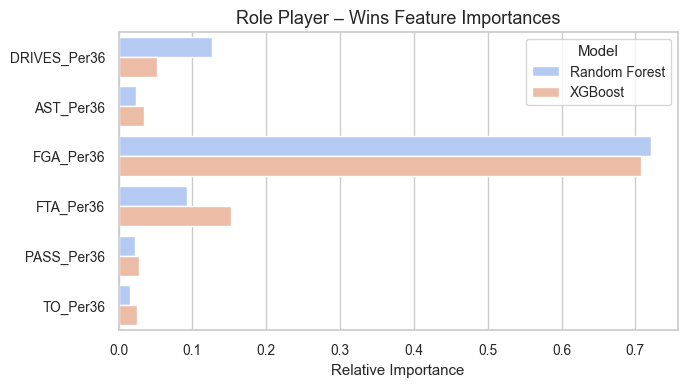

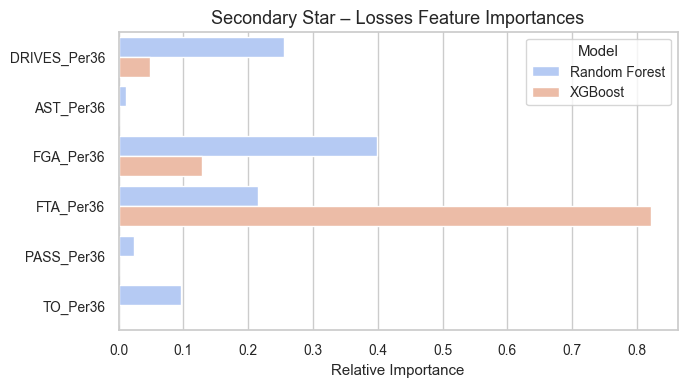

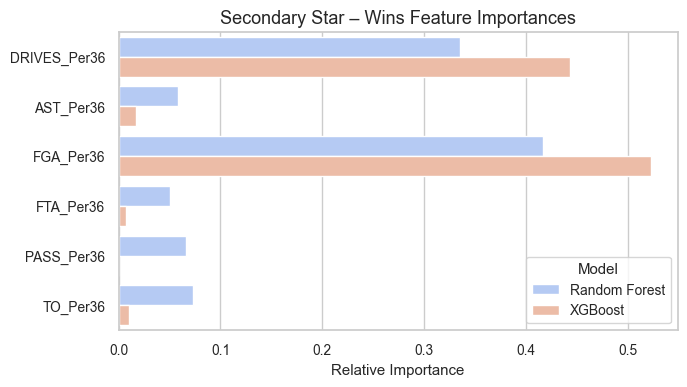

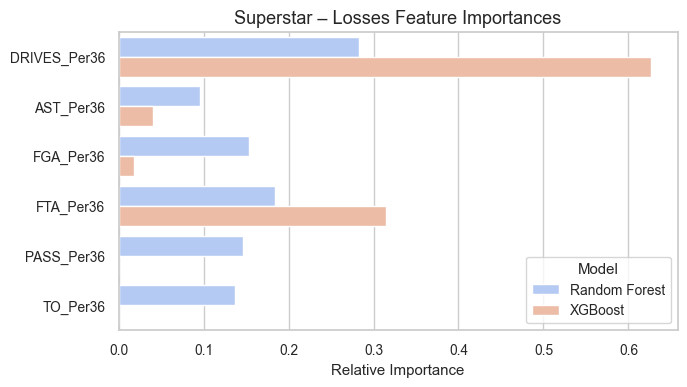

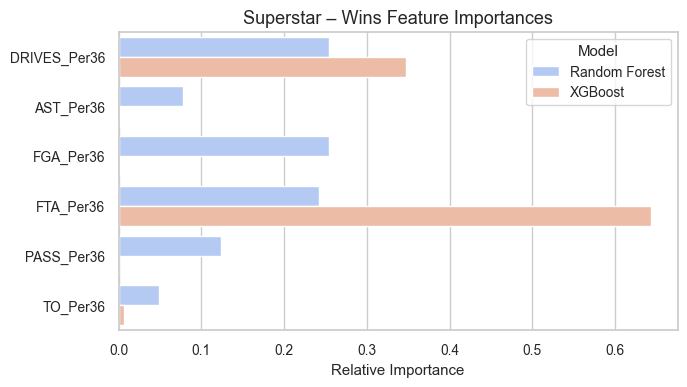

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

features = ["DRIVES_Per36", "AST_Per36", "FGA_Per36", "FTA_Per36", "PASS_Per36", "TO_Per36"]
target = "PTS_Per36"

results = []

feature_importance_data = []

# --- Loop through tiers and outcomes ---
for tier in ["Superstar", "Secondary Star", "Role Player"]:
    for outcome, df in [("Wins", wins_df), ("Losses", losses_df)]:
        data = df[df["Tier"] == tier].dropna(subset=features + [target])
        if len(data) < 5:  # skip small samples
            continue

        X = data[features]
        y = data[target]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42
        )

        # --- Random Forest Model ---
        rf = RandomForestRegressor(n_estimators=250, random_state=42)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)
        r2_rf = r2_score(y_test, y_pred_rf)
        rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

        # --- XGBoost Model ---
        xgb = XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            random_state=42,
            verbosity=0
        )
        xgb.fit(X_train, y_train)
        y_pred_xgb = xgb.predict(X_test)
        r2_xgb = r2_score(y_test, y_pred_xgb)
        rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

        # --- Store Results ---
        results.extend([
            {"Tier": tier, "Outcome": outcome, "Model": "Random Forest", "R²": round(r2_rf, 3), "RMSE": round(rmse_rf, 3)},
            {"Tier": tier, "Outcome": outcome, "Model": "XGBoost", "R²": round(r2_xgb, 3), "RMSE": round(rmse_xgb, 3)},
        ])

        # --- Store Feature Importances ---
        for model, model_name in [(rf, "Random Forest"), (xgb, "XGBoost")]:
            importances = pd.DataFrame({
                "Feature": features,
                "Importance": model.feature_importances_,
                "Tier": tier,
                "Outcome": outcome,
                "Model": model_name
            })
            feature_importance_data.append(importances)

# --- Combine Results ---
results_df = pd.DataFrame(results)
feature_importance_df = pd.concat(feature_importance_data, ignore_index=True)

# --- Display Model Performance Summary ---
print("Model Performance Summary")
display(results_df)

# --- Plot Feature Importances ---
sns.set_theme(style="whitegrid", font_scale=0.9)

for (tier, outcome), group in feature_importance_df.groupby(["Tier", "Outcome"]):
    plt.figure(figsize=(7, 4))
    sns.barplot(
        data=group,
        x="Importance",
        y="Feature",
        hue="Model",
        palette="coolwarm"
    )
    plt.title(f"{tier} – {outcome} Feature Importances", fontsize=13)
    plt.xlabel("Relative Importance")
    plt.ylabel("")
    plt.legend(title="Model", loc="best")
    plt.tight_layout()
    plt.show()

## Model Performance Interpretation

The Random Forest and XGBoost regressors were trained to predict **player scoring output (PTS_Per36)** using key performance metrics such as drives, assists, shot attempts, and turnovers. Results were evaluated using **R²** (explained variance) and **RMSE** (error magnitude) for each player tier in both **Wins** and **Losses** datasets.

### Superstars
- **XGBoost outperformed Random Forest** in wins (R² = 0.645 vs. 0.479), suggesting that gradient boosting captured more of the underlying non-linear relationships in scoring efficiency during successful games.  
- In **losses**, both models showed weaker predictive power (R² < 0.35), indicating that superstar scoring variability in losing situations is likely influenced by external factors not captured in this dataset (e.g., defensive attention, team context, or game pacing).  
- Overall, the lower R² values suggest that for elite players, scoring outcomes are less predictable from raw statistical drivers—likely because their performance adapts to team needs and defensive schemes.

### Secondary Stars
- Both models performed **exceptionally well**, particularly in wins (R² ≈ 0.88 for both models), showing high predictive accuracy and low RMSE values.  
- Even in losses, the models maintained strong performance (R² ≈ 0.80), implying that secondary stars have more **consistent scoring patterns** tied closely to measurable stats like FGA, FTA, and assists.  
- These results suggest that secondary stars’ roles are more structured and predictable, leading to stable statistical relationships with scoring output.

### Role Players
- Predictive performance was strong in wins (R² ≈ 0.81 for XGBoost, 0.76 for Random Forest) and moderate in losses (R² ≈ 0.62).  
- This implies that role players’ scoring in wins is more systematic—driven by repeatable metrics like drives and efficiency opportunities—while losses introduce more variability or reduced involvement.  
- The smaller RMSE values compared to superstars also indicate tighter clustering of scoring performance within this group.

### Comparative Insights
- **Model hierarchy:** XGBoost consistently outperformed Random Forest in most cases, though the margin was smaller for structured roles (secondary stars, role players).  
- **Tier pattern:** Predictability follows a clear trend —  
  **Secondary Stars > Role Players > Superstars**, highlighting that players with defined offensive roles exhibit more statistically consistent scoring behavior.  
- **Wins vs. Losses:** Across all tiers, R² scores were higher in wins, suggesting that team success aligns with more predictable individual scoring contributions.
